### Download and preprocess the dataset

In [1]:
import pandas as pd

data_file_path = "sms+spam+collection/SMSSpamCollection"
df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [2]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


In [3]:
### For simplicity and because we prefer a small dataset, we subsample the dataset so that it contains 747 instances from each class

In [4]:
def create_balanced_dataset(df):
    # Count the instances of "spam"
    num_spam = df[df["Label"] == "spam"].shape[0]
    
    # Randomly sample "ham" instances to match the number of "spam" instances
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)
    
    # Combine ham subset with spam
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])
    
    return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [5]:
# next we convert the string class labels "ham" and "spam" into integer class labels 0 and 1 respectively
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

In [6]:
# Create a random_split function to split the dataset into three parts: 70% train, 10% val, 20% test.
def random_split(df, train_frac, validation_frac):
    # Shuffle the entire df
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)
    
    # Calculate split indices
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)
    
    # Split the df
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]
    
    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)

In [7]:
# Save the dataset as CSV files
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

### Creating dataloaders

In [8]:
### The SpamDataset class handle several key tasks: it identifies the longest sequence in the training dataset, encodes the text
### messages, and ensures all other sequences are padded with a padding token to match the length of the longest sequence.

In [9]:
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)
        
        # Pre-tokenize texts
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]
        
        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            
            # Truncate sequences if they are longer than max_length
            self.encoded_texts = [
                encoded_text[:self.max_length] for encoded_text in self.encoded_texts
            ]
        
        # Pad sequences to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

In [10]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length)

120


In [11]:
### Note that the model can handle sequences of up to 1024 tokens, given its context length limit.
### If the dataset includes longer texts, you can pass max_length=1024 when creating the training dataset in the preceding code 
### to ensure that the data does not exceed the models supported context length.

In [12]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

In [13]:
### Using the datasets as inputs, we can instantiate the dataloaders similarly to what we did earlier
### However, in this case, the targets represent class labels rather than the next tokens in the text.
### For instance, choosing a batch size of 8, each batch will consist of 8 training examples of length 120.

In [14]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False
)

In [15]:
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions:", target_batch.shape)

Train loader:
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions: torch.Size([8])


In [16]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


### Initializing a model with pretrained weights

In [27]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG["context_length"]}. Reinitialize datasets with "
    f"max_length={BASE_CONFIG["context_length"]} "
)

In [28]:
import sys
import os

# Add the parent directory to the path so 'utils' can be found
sys.path.append(os.path.abspath('..'))

In [29]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

from GPTModel import GPTModel, load_weights_into_gpt
from gpt_download import download_and_load_gpt2

settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

c:\CS\LLMS_FROM_SCRATCH_27_05\venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up to date: gpt2\124M\checkpoint


c:\CS\LLMS_FROM_SCRATCH_27_05\venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up to date: gpt2\124M\encoder.json


c:\CS\LLMS_FROM_SCRATCH_27_05\venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up to date: gpt2\124M\hparams.json


c:\CS\LLMS_FROM_SCRATCH_27_05\venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up to date: gpt2\124M\model.ckpt.data-00000-of-00001


c:\CS\LLMS_FROM_SCRATCH_27_05\venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up to date: gpt2\124M\model.ckpt.index


c:\CS\LLMS_FROM_SCRATCH_27_05\venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up to date: gpt2\124M\model.ckpt.meta


c:\CS\LLMS_FROM_SCRATCH_27_05\venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up to date: gpt2\124M\vocab.bpe


In [30]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

In [32]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # Add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # Remove batch dimension
    return tokenizer.decode(flat.tolist())

def generate_text_simple(model, idx, max_new_tokens, context_size):
    
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceed the supported context size
        # ex: if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)
            
        # Focus only on the last time step
        # (batch, n_tokens, voacb_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]
        
        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)
        
        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)   # (batch, 1)
        
        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)    # (batch, n_tokens + 1)
    
    return idx

In [ ]:
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(INPUT_PROMPT, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves forward, but it's not enough.

"I'm not going


In [34]:
text_1 = (
    """
    Is the following text 'spam'? Answer with 'yes' or 'no':
    'You are a winner you have been specially selected to receive 
    $1000 cash or a $2000 award.
    """
)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))


    Is the following text 'spam'? Answer with 'yes' or 'no':
    'You are a winner you have been specially selected to receive 
    $1000 cash or a $2000 award.
     You have been specially selected to receive $1000 cash or a $2000 award.
     You have


### Adding a classification head

In [35]:
### We replace the original output layer which maps the hidden representation to a vocab of 50257 with a smaller output layer that
### maps to two classes: 0 and 1

### We could technically use a single output node since we are dealing with a binary classification task.
### However, this would require modifying the loss function.
### Therefore, we choose a more general approach where the number of output nodes matches the number of classes.

In [36]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [37]:
### We replace the out_head with a new output layer that we will finetune.
### To get the model ready for classification finetuning, we first freeze the model, meaning that we make all layers non trainable.

In [38]:
for param in model.parameters():
    param.requires_grad = False

In [39]:
torch.manual_seed(123)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

In [40]:
### This new model.out_head output layer has its requires_grad attribute set to True by default, which means that its the only
### layer in the model that will be updated during training.

In [41]:
# Additionally, we configure the last transformer block and final LayerNorm module, which connects this block to the output layer
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

In [ ]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape)   # (batch_size, num_tokens)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


In [43]:
with torch.no_grad():
    outputs = model(inputs)

print("Outputs:\n", outputs)
print("Output dimensions:", outputs.shape)  # (batch_size, num_tokens, num_classes)

Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Output dimensions: torch.Size([1, 4, 2])


In [44]:
### We are interested in finetuning this model so that it returns a class label that indicates whether a model input is spam
### or not spam. To achieve this, we dont need to fnetune all 4 output rows but can focus on a single output token.
### In particular, we will focus on the last row corresponding to the last output token

In [45]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])


### Calculating the classification loss and accuracy

In [47]:
# We obtain the class label 
probas = torch.softmax(outputs[:, -1, :], dim=-1)
print(probas)
label = torch.argmax(probas)
print("Class label:", label.item())

tensor([[5.0598e-04, 9.9949e-01]])
Class label: 1


In [48]:
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("Class label:", label.item())

Class label: 1


In [49]:
### To determine the classification accuracy, we apply the argmax based prediction code to all examples in the dataset and calculate
### the proportion of correct predictions by defining a calc_accuracy_loader function

In [50]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0
    
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)
            
            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]   # Logits of the last output token
            predicted_labels = torch.argmax(logits, dim=-1)
            
            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
torch.manual_seed(123)

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


In [52]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [53]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceed the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [54]:
with torch.no_grad():   # Disable gradient tracking for efficiency because we are not training yet
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.453
Validation loss: 2.583
Test loss: 2.322


### Finetuning the model on supervised data

In [55]:
### Step 1: Set model to training mode
### Step 2: Reset loss gradients from previous batch iteration
### Step 3: Calculate loss gradients
### Step 4: Update model weights using loss gradients
### Step 5: NewL track examples instead of tokens
### Step 6: Optional evaluation step
### Step 7: Calculate accuracy after each epoch

In [56]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [59]:
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter):
    # initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1
    
    # Main training loop
    for epoch in range(num_epochs):
        model.train()   # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()   # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step()    # Updates model weights using loss gradients
            examples_seen += input_batch.shape[0]  # track examples instead of tokens
            global_step += 1
            
            # optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
        
        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)
        
    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [60]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device, num_epochs=num_epochs, eval_freq=50, eval_iter=5
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 1.977, Val loss 2.196
Ep 1 (Step 000050): Train loss 0.615, Val loss 0.636
Ep 1 (Step 000100): Train loss 0.520, Val loss 0.555
Training accuracy: 70.00% | Validation accuracy: 72.50%
Ep 2 (Step 000150): Train loss 0.563, Val loss 0.488
Ep 2 (Step 000200): Train loss 0.418, Val loss 0.395
Ep 2 (Step 000250): Train loss 0.408, Val loss 0.352
Training accuracy: 82.50% | Validation accuracy: 85.00%
Ep 3 (Step 000300): Train loss 0.330, Val loss 0.314
Ep 3 (Step 000350): Train loss 0.278, Val loss 0.181
Training accuracy: 90.00% | Validation accuracy: 92.50%
Ep 4 (Step 000400): Train loss 0.076, Val loss 0.131
Ep 4 (Step 000450): Train loss 0.125, Val loss 0.099
Ep 4 (Step 000500): Train loss 0.202, Val loss 0.102
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.206, Val loss 0.110
Ep 5 (Step 000600): Train loss 0.067, Val loss 0.056
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training completed in 0.58 mi

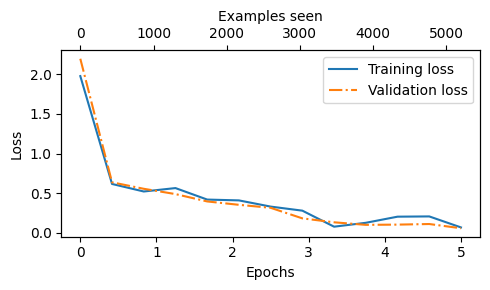

In [64]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    
    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()
    
    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()   # Creates a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)    # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")
    
    fig.tight_layout()
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

In [62]:
# No indication of overfitting

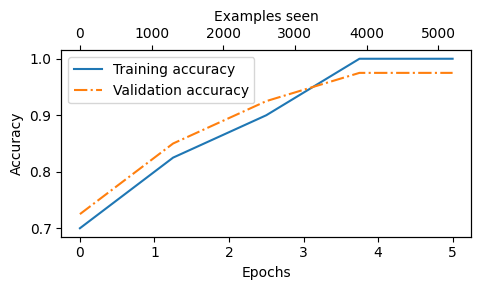

In [65]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [66]:
### Note that we previously set eval_iter=5 when using the train_classifier_simple function, which means our estimations of 
### training and validation performance were based on only 5 batches for efficiency during training.
### We will now calculate the performance metrics for the training, validation and test sets across the entire dataset 
### without defining the eval_iter value

In [67]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 97.60%
Validation accuracy: 97.32%
Test accuracy: 96.00%


### Using the LLM as a spam classifier

In [68]:
### Step 1: Prepare inputs to the model
### Step 2: Truncate sequences if they are too long
### Step 3: Pad sequences to the longest sequence
### Step 4: Add batch dimension
### Step 5: Model inference without gradient tracking
### Step 6: Logits of the last output token
### Step 7: Return the classified result

In [69]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()
    
    # Prepare inputs to the model
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]
    
    # truncate sequences if they are too long
    input_ids = input_ids[:min(max_length, supported_context_length)]
    
    # Pad sequences to the longest sequence
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0)
    
    # Model inference
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]  # Logits of the last output token
    predicted_label = torch.argmax(logits, dim=-1).item()
    
    return "spam" if predicted_label == 1 else "not spam"

In [71]:
text_2 = (
    """
    You are a winner you have been specially selected to receive 
    $1000 cash or a $2000 award.
    """
)

print(classify_review(text_2, model, tokenizer, device, max_length=train_dataset.max_length))

spam


In [73]:
text_3 = (
    """
    Hey, just wanted to check if we're still on for dinner tonight?
    let me know!
    """
)

print(classify_review(text_3, model, tokenizer, device, max_length=train_dataset.max_length))

not spam


In [74]:
torch.save(model.state_dict(), "review_classifier.pth")

In [75]:
model_state_dict = torch.load("review_classifier.pth")
model.load_state_dict(model_state_dict)

<All keys matched successfully>